In [56]:
import gensim
from gensim import corpora
import MeCab
import math
from collections import defaultdict
from sklearn.utils import shuffle
from keras.layers          import Input, Dense, Dropout
from keras.models          import Model,Sequential
from keras.optimizers      import Adam
import math
import matplotlib.pyplot as plt
from keras.utils import plot_model
import numpy as np

In [81]:
categories=6
topics_num=512

In [59]:
def plot_history(history):
    # 精度の履歴をプロット
    plt.plot(history.history['acc'],"o-",label="accuracy")
    plt.plot(history.history['val_acc'],"o-",label="val_acc")
    plt.title('model accuracy')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.legend(loc="lower right")
    plt.show()

    # 損失の履歴をプロット
    plt.plot(history.history['loss'],"o-",label="loss",)
    plt.plot(history.history['val_loss'],"o-",label="val_loss")
    plt.title('model loss')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(loc='lower right')
    plt.show()

In [60]:
def onehot_vector(number):
    global categorie
    onehot=np.zeros(categories)
    onehot[number]=1
    return onehot

In [61]:
def extractKeyword(text,word_class):
    tagger = MeCab.Tagger('-Ochasen')
    tagger.parse('') # <= 空文字列をparseする
    node = tagger.parseToNode(text)
    keywords = []
    while node:
        if node.feature.split(",")[0] == word_class:
            keywords.append(node.surface)
        node = node.next
    return keywords

In [62]:
def load_file(filename):
    texts=[]
    labels=[]
    with open(filename, "r") as f:
        lines = [line for line in f]
        for line in lines:
            title,category=line.split(" ")
            texts.append(extractKeyword(title,"名詞"))  
            labels.append(onehot_vector(int(category)))
    texts,labels=shuffle(texts,labels)
    return texts,labels

In [63]:
def train_test_divide(texts,test_rate):
    datanum=len(texts)
    n=math.floor(datanum*test_rate)
    train_texts=texts[:datanum-n]
    test_texts=texts[datanum-n:]
    return train_texts,test_texts

In [64]:
def remove_rare_words(texts):
    # 単語の出現回数を格納するfrequency変数を定義
    frequency = defaultdict(int)
    # 単語の出現回数をfrequency変数でカウント
    for text in texts:
         for token in text:
            frequency[token] += 1
    # frequency変数で1より上の単語のみを配列に構築
    removed_texts = [[token for token in text if frequency[token] > 1] for text in texts]
    return removed_texts

In [65]:
def create_texts(filename):
    texts,labels=load_file(filename)
    texts=remove_rare_words(texts)
    return texts,labels

In [66]:
def create_dictionary(train_texts):
    dictionary = corpora.Dictionary(train_texts)
    dictionary.save('lda.dict')
    return dictionary

In [67]:
def create_corpus(texts,dictionary):
    corpus = [dictionary.doc2bow(text) for text in texts]
    return corpus

In [84]:
def create_lda(train_corpus,dictionary,topics_num):
    lda = gensim.models.ldamodel.LdaModel(corpus=train_corpus, num_topics=topics_num, id2word=dictionary)
    return lda

In [70]:
def classify(LDA,test_corpus,topics_num):
    output=[]
    for j in range(len(test_corpus)):
        L=[LDA[test_corpus[j]][i][1] for i in range(topics_num)]
        output.append(L.index(max(L)))
    return output

In [75]:
def corpus2inputData(corpus,topics_num):
    input_data=[]
    for i in range(len(corpus)):
        L=LDA[corpus[i]]
        _input=[0]*topics_num
        for item in L:
            _input[item[0]]=item[1]
        input_data.append(np.array(_input))
    input_data=np.array(input_data)
    print(input_data.shape)
    return input_data

In [85]:
#LDAモデル作成
texts,labels=create_texts("news_data.txt")
train_texts,test_texts=train_test_divide(texts,0.1)
Y_train,Y_test=train_test_divide(labels,0.1)
dictionary=create_dictionary(train_texts)
train_corpus=create_corpus(train_texts,dictionary)
test_corpus=create_corpus(test_texts,dictionary)
LDA=create_lda(train_corpus,dictionary,topics_num)

In [86]:
X_train=corpus2inputData(train_corpus,topics_num)
X_test=corpus2inputData(test_corpus,topics_num)

(75708, 512)
(8412, 512)


In [87]:
Y_train=np.array(Y_train)
Y_test=np.array(Y_test)

In [88]:
print(Y_train.shape)
print(Y_test.shape)

(75708, 6)
(8412, 6)


In [91]:
#モデル作成
model = Sequential()
model.add(Dense(512, input_dim=topics_num,activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(categories, activation='softmax'))
model.summary()
model.compile(optimizer=Adam(), loss='categorical_crossentropy',metrics=["accuracy"])
#モデル学習
history =model.fit(X_train,Y_train,shuffle=True,batch_size=1000,epochs=30,
                   validation_split=0.1)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_13 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_14 (Dense)             (None, 128)               65664     
_________________________________________________________________
dense_15 (Dense)             (None, 6)                 774       
Total params: 329,094
Trainable params: 329,094
Non-trainable params: 0
_________________________________________________________________
Train on 68137 samples, validate on 7571 samples
Epoch 1/30
68137/68137 [==============================] - 1s - loss: 1.4225 - acc: 0.5302 - val_loss: 1.0685 - val_acc: 0.6076
Epoch 2/30
68137/68137 [==============================] - 0s - loss: 1.0286 - acc: 0.6279 - val_loss: 1.0372 - val_acc: 0.6199
Epoch 3/30
68137/68137 [==============================] - 0s - loss: 1.0026 - acc: 0.6362 - val_l

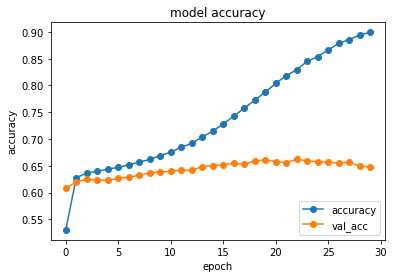

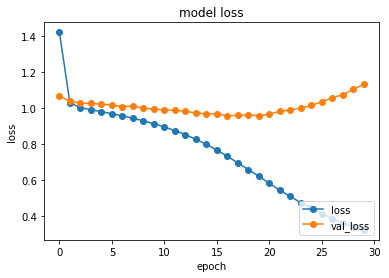

7680/8412 [==========================>...] - ETA: 0s
loss:1.1177340501612048 accuracy:0.6564431763579603


In [92]:
plot_history(history)
loss_and_metrics = model.evaluate(X_test,Y_test)
print("\nloss:{} accuracy:{}".format(loss_and_metrics[0],loss_and_metrics[1]))